In [126]:
import pandas as pd
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce

In [128]:
data = pd.read_csv("Data/new_data.csv")

In [129]:
# data.head()

In [130]:
# data.info()

In [131]:
data = data.drop(columns=['Title', 'Synopsis', 'Edition_year'])

In [132]:
# data = data.loc[(data['Price'] <= 700) & (data['Price'] >=200)]

In [133]:
data.shape

(6237, 7)

In [134]:
Y = data['Price']

In [135]:
X = data.drop(columns=['Price'])

In [136]:
ce_bin = ce.BinaryEncoder(cols = ['BookCategory', 'Genre','Author','Edition_type'])
X = ce_bin.fit_transform(X, Y)

In [137]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [138]:
# x = pd.concat((x_train, y_train), axis=1)

In [139]:
# x = x.loc[(x['Price'] >=200) & (x['Price'] <=2000)]

In [140]:
# x_train = x.drop(columns=['Price'])

In [141]:
# y_train = x['Price']

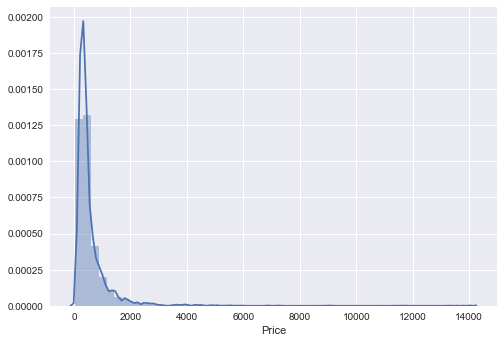

In [142]:
sns.distplot(y_train);
plt.show()

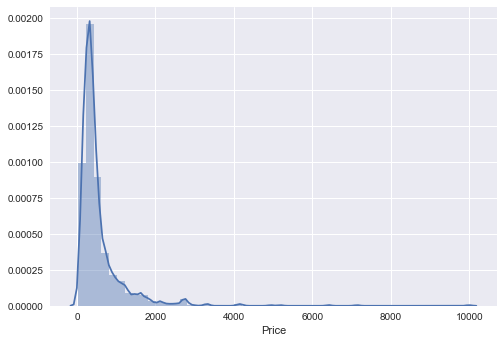

In [143]:
sns.distplot(y_test);
plt.show()

In [113]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3204, 31), (801, 31), (3204,), (801,))

In [144]:
reg_model = DecisionTreeRegressor(max_depth=3)

In [145]:
# reg_model = linear_model.Ridge(alpha=100.0,)

In [146]:
reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [147]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

Train error:  0.7483328845930912


In [149]:
predictions = list(reg_model.predict(x_test))

In [150]:
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.741349418300183


In [77]:
# for i, j in zip(y_test[10:50], reg_model.predict(x_test)[10:50]):
#     print(i, j)

In [ ]:
# write predictions to an excel file

# preds = np.array(predictions)
# preds = pd.DataFrame(preds, columns=['Price'])
# preds.to_excel("submission.xlsx", index=None)

In [114]:
train_errors, test_errors, depths = [], [], [] 

In [115]:
for depth in range(2, 30):
    reg_model = DecisionTreeRegressor(max_depth=depth)
    reg_model.fit(x_train, y_train)
    train_err = np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train)))
    test_err = np.sqrt(mean_squared_log_error(y_test, reg_model.predict(x_test)))
    train_errors.append(train_err)
    test_errors.append(test_err)
    depths.append(depth)

In [122]:
d = pd.DataFrame({"train_error": train_errors, "test_error": test_errors, "depths": depths})

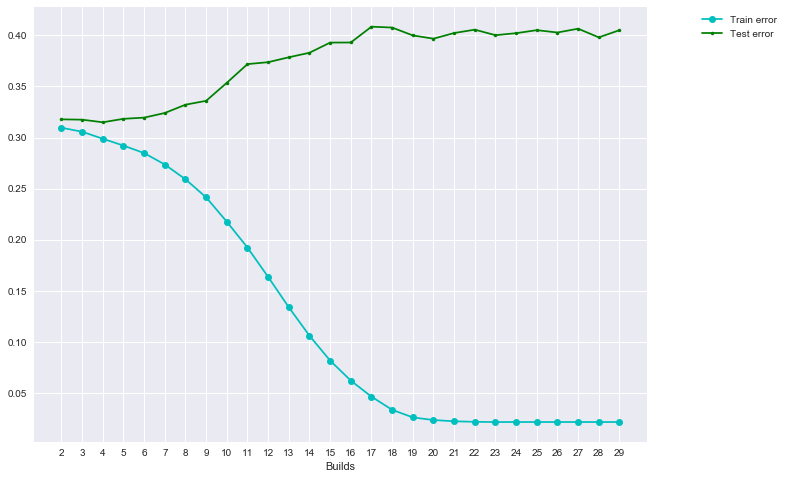

In [123]:
builds = d['depths']
y_stack = np.row_stack((d['train_error'], d['test_error'])) 

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(builds, y_stack[0,:], label='Train error', color='c', marker='o')
ax1.plot(builds, y_stack[1,:], label='Test error', color='g', marker='.')

plt.xticks(builds)
plt.xlabel('Builds')

handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')

plt.show()